# Data Cleaning and Investigation

In [1]:
import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Chicago Divvy Bike Data ##

I downloaded Chicago Divvy data for the last quarter before the pandemic (Q4 of 2019) from:
https://divvy-tripdata.s3.amazonaws.com/index.html

Map of the system is here:
https://member.divvybikes.com/map/

List of stations can be found here:
https://data.cityofchicago.org/Transportation/Divvy-Bicycle-Stations/bbyy-e7gq/data

The downloaded dataset has more than 700K rides, and the I am choosing to focus on rides centered around my campus in Hyde Park.

In [2]:
bike = pd.read_csv("Bike.csv")
bike.head(5)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
0,25317046,10/7/19 13:39,10/7/19 14:05,4231,1533.0,424,Museum of Science and Industry,355,South Shore Dr & 67th St,Customer,NaN,NaN
1,25577704,10/27/19 16:44,10/27/19 16:49,523,283.0,345,Lake Park Ave & 56th St,423,University Ave & 57th St,Subscriber,Male,1989.0
2,25823341,12/4/19 17:24,12/4/19 17:32,376,486.0,423,University Ave & 57th St,419,Lake Park Ave & 53rd St,Subscriber,Male,1993.0
3,25735449,11/19/19 18:32,11/19/19 18:35,5708,174.0,248,Woodlawn Ave & 55th St,322,Kimbark Ave & 53rd St,Subscriber,Male,1998.0
4,25716762,11/16/19 21:09,11/16/19 21:19,1993,633.0,322,Kimbark Ave & 53rd St,426,Ellis Ave & 60th St,Subscriber,Male,2001.0


In [3]:
#function to calculate the number of duplicated rows
def num_dupe_func(df):
    df_nodupe = df.drop_duplicates()
    return len(df) - len(df_nodupe)
num_dupe_func(bike)

20

In [4]:
#creating df with no duplicates
bikeND = bike.drop_duplicates()

In [5]:
#columns with missing values
print('columns with missing values:')
print(bikeND.isnull().sum())

columns with missing values:
trip_id                0
start_time             0
end_time               0
bikeid                 0
tripduration           0
from_station_id        0
from_station_name      2
to_station_id          0
to_station_name        2
usertype               0
gender               206
birthyear            199
dtype: int64


In [6]:
#missing rows
nullrows = bikeND.isnull().any(axis='columns')
print('# missing rows:', nullrows.sum())

# missing rows: 210


In [7]:
#investigating how missing values differ by user type
null_df = bikeND[nullrows]
null_df.head(10)
null_df.groupby(by='usertype').count()

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,gender,birthyear
usertype,,,,,,,,,,,
Customer,199,199,199,199,199,199,199,199,199,0,0
Subscriber,11,11,11,11,11,11,9,11,9,4,11


The table above counts the non null values in each column grouped by user type from a table containing only all the rows with null values. Based on the this, customers are only missing data in their gender and birthyear columns. Subscribers are missing two values 'from station' names and two values 'to station' names, and seven subscribers are missing their gender as well (all birth years are there). 

### Filling in missing station names using station ids

In [8]:
id_name = bikeND.iloc[:,[5,6]].drop_duplicates()

In [9]:
#find index and missing station names
filled_df = bikeND.iloc[:,[5,6,7,8]].fillna(0)
print(filled_df[filled_df.iloc[:,1]==0])
print(filled_df[filled_df.iloc[:,3]==0])

     from_station_id from_station_name  to_station_id      to_station_name
12               423                 0            418  Ellis Ave & 53rd St
175              418                 0            328  Ellis Ave & 58th St
     from_station_id         from_station_name  to_station_id to_station_name
44               423  University Ave & 57th St            426               0
276              345   Lake Park Ave & 56th St            423               0


In [10]:
#find station name based on station id
print(id_name[id_name.from_station_id==423])
print(id_name[id_name.from_station_id==418])
print(id_name[id_name.from_station_id==426])

    from_station_id         from_station_name
2               423  University Ave & 57th St
12              423                       NaN
     from_station_id    from_station_name
9                418  Ellis Ave & 53rd St
175              418                  NaN
    from_station_id    from_station_name
46              426  Ellis Ave & 60th St


In [11]:
bikeND.loc[12, 'from_station_name'] = 'University Ave & 57th St'
bikeND.loc[175, 'from_station_name'] = 'Ellis Ave & 53rd St'
bikeND.loc[44, 'to_station_name'] = 'Ellis Ave & 60th St'
bikeND.loc[276, 'to_station_name'] = 'University Ave & 57th St' 

In [12]:
#check that station names are imputed
bikeND.loc[[12,175,44,276],:]

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
12,25600923,10/29/19 17:49,10/29/19 17:54,2054,328.0,423,University Ave & 57th St,418,Ellis Ave & 53rd St,Subscriber,Male,1980.0
175,25507288,10/21/19 8:38,10/21/19 8:42,4392,288.0,418,Ellis Ave & 53rd St,328,Ellis Ave & 58th St,Subscriber,Female,2000.0
44,25601662,10/29/19 18:23,10/29/19 18:27,486,248.0,423,University Ave & 57th St,426,Ellis Ave & 60th St,Subscriber,Male,2000.0
276,25366919,10/10/19 8:10,10/10/19 8:15,875,292.0,345,Lake Park Ave & 56th St,423,University Ave & 57th St,Subscriber,Male,1986.0


## Investigating the Data

### What was the longest ride?

In [13]:
bikeND.sort_values(by = 'tripduration', ascending = False).head(1)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear
408,25575836,10/27/19 15:12,10/28/19 14:09,1187,82667.0,424,Museum of Science and Industry,653,Cornell Dr & Hayes Dr,Customer,NaN,NaN


### Where do people go when they take long trips?

In [14]:
#top 244 longest trips (top 10%)
sort_tripdur = bikeND.sort_values(by='tripduration', ascending = False).iloc[0:244]

#where do they go?
end_where = sort_tripdur.groupby(by='to_station_name').count().idxmax()

#select out msi
msi_df = sort_tripdur[sort_tripdur.to_station_id==424]

#when do they arrive? what day of the week?
go_when = msi_df.groupby(by='end_hour').count().idxmax()
week_when = msi_df.groupby(by='weekday').count().idxmax()

print('most common ending location:', end_where[0])
print('most common hour of arrival:', go_when[0])
print('most common weekday to go:', week_when[0])

KeyError: 'end_hour'

I chose to look into where people tended to go when they took longer trips. I sorted the dataframe by trip duration and selected the top 244 longest trips which would be the top 10%. From there, I looked at where people went by grouping the dataframe by the 'to_station_name' column. It turns out that the top 10% longest trips were to the Museum of Science and Industry. Next, I wanted to investigate when people got there and on what day of the week. Thus, I selected out the MSI as the final destination and I looked into when the most common time that people got there was and on what day of the week they went. Ultimately, it turns out the top 10% of longest rides are to the MSI on Sunday, arriving at 1 PM! Sounds like a good way to spend a Sunday :) 

### How do durations of trips differ between men and women?

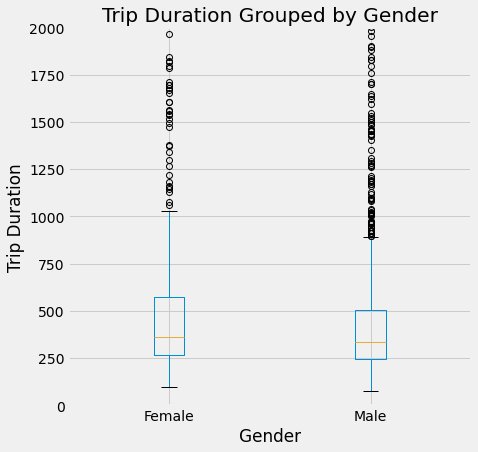

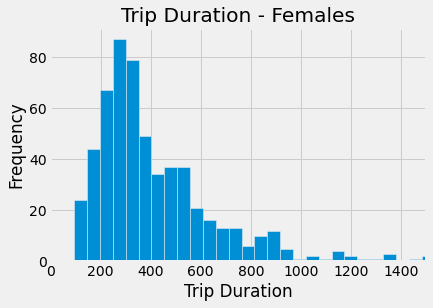

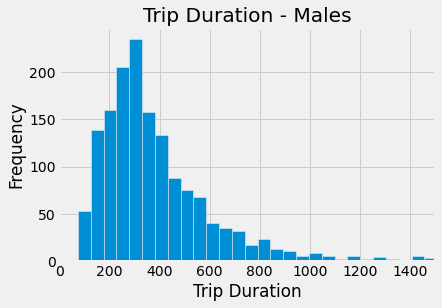

In [16]:
females = bikeND[bikeND.gender=='Female']
males = bikeND[bikeND.gender=='Male']

bikeND.boxplot(by = 'gender', column = 'tripduration', figsize=(7,7)) 
plots.title('Trip Duration Grouped by Gender')
plots.ylabel('Trip Duration')
plots.xlabel('Gender')
plots.suptitle('')
plots.ylim(0,2000)
plots.show()

females.hist(column = 'tripduration', bins=1000)
plots.title('Trip Duration - Females')
plots.xlabel('Trip Duration')
plots.ylabel('Frequency')
plots.xlim(0,1500)
plots.show()

males.hist(column = 'tripduration', bins=1500)
plots.title('Trip Duration - Males')
plots.xlabel('Trip Duration')
plots.ylabel('Frequency')
plots.xlim(0,1500)
plots.show()

The boxplot shows us that men have a smaller IQR, and the median trip duration appears slightly shorter for men than women. Men also appear to have more outliers beyond the max. Based on the histograms, both men and women have similar distributions in their trip durations, but it is harder to discern differences between the genders here. 

### How does age (being in college vs not) impact trip duration?

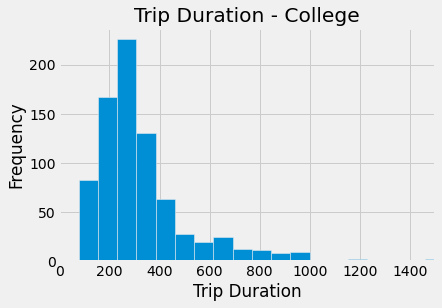

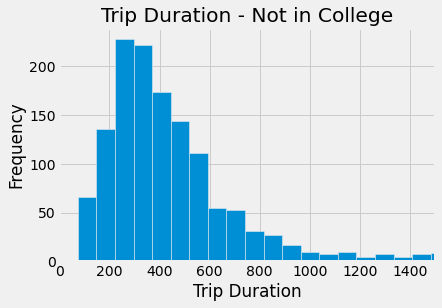

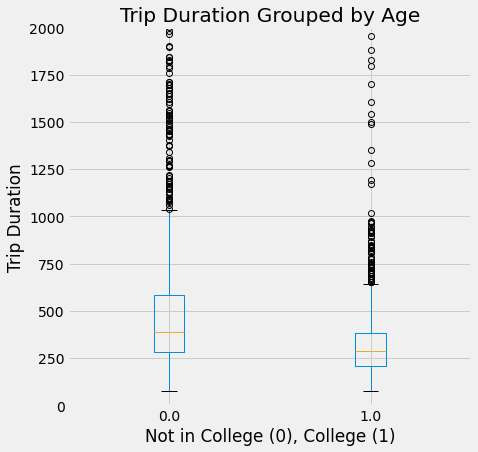

In [17]:
no_nas = bikeND.dropna()
college = np.ones(no_nas.shape[0])
college[no_nas.birthyear<1997]=0 #not college
college[no_nas.birthyear>2001]=0 #not college
no_nas.insert(12, 'college', college)
no_nas.head(12)

students = no_nas[no_nas.college==1]
notstud = no_nas[no_nas.college==0]
students.hist(column = 'tripduration', bins=1000)
plots.title('Trip Duration - College')
plots.xlabel('Trip Duration')
plots.ylabel('Frequency')
plots.xlim(0,1500)
plots.show()

notstud.hist(column = 'tripduration', bins=150)
plots.title('Trip Duration - Not in College')
plots.xlabel('Trip Duration')
plots.ylabel('Frequency')
plots.xlim(0,1500)
plots.show()

no_nas.boxplot(by = 'college', column = 'tripduration', figsize=(7,7)) 
plots.title('Trip Duration Grouped by Age')
plots.suptitle('')
plots.ylabel('Trip Duration')
plots.xlabel('Not in College (0), College (1)')
plots.ylim(0,2000)
plots.show()

The histograms show similar distributions (both right skewed), however, college students generally take shorter rides as that distribution is very strongly right skewed. The boxplot supports what is seen in the histograms. The college student trip duration median is less than that of individuals not in college, and their IQR is also much smaller. The college max duration is also much lower than the non college max trip duration. Hence, college students generally take shorter rides. 

In [18]:
#Calculating Age v Trip Duration
age = 2021-no_nas.birthyear
no_nas.insert(13, 'age', age)

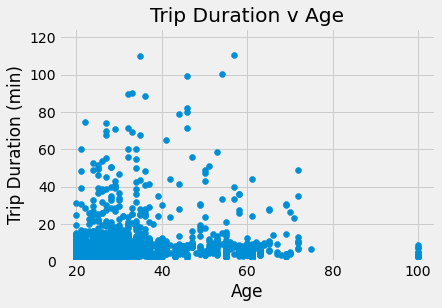

In [20]:
plots.scatter(no_nas.age, no_nas.tripduration/60)
plots.ylim(0,125)
plots.xlabel('Age')
plots.ylabel('Trip Duration (min)')
plots.title('Trip Duration v Age')
plots.show()

There does not appear to be much of trend regarding trip duration and age, although most of the points are between ages 20-40. There also appears to be a substational amount of points between 40-60, but not as many. The trip duration is generally less than 20 minutes, and younger riders (20-40) take more longer trips than individuals over 40. 

### Exploring trip duration by day of the week

In [21]:
dow = pd.DatetimeIndex(bikeND['start_time']).day_name()
bikeND.insert(12, 'weekday', dow)
downum = pd.DatetimeIndex(bikeND['start_time']).dayofweek
bikeND.insert(13, 'weekday_num', downum)

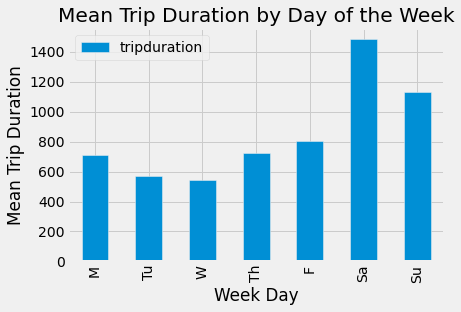

In [22]:
dow_mean = bikeND.groupby(by='weekday_num').mean()
dow_mean['Week Day'] = ['M', 'Tu', 'W', 'Th', 'F', 'Sa', 'Su']
dow_mean.plot.bar(x = 'Week Day', y = 'tripduration')
plots.ylabel('Mean Trip Duration')
plots.title('Mean Trip Duration by Day of the Week')
plots.show()

The plot above shows the average trip duration by the day of the week. On average, it appears the longest trips are taken on Saturday and the shortest trips are taken on Wednesday. In general, the weekend (Fri, Sat, Sun) has the longest average trips which is to be expected since people have more time to go out and do things. 

### Trips to and from our main campus library
Station 423 is in front of the Regenstein Library. I want to know what the most common hour of the day is (10am, 11pm etc) to start and end a trip there.

All the trips that start between 10:00am and 10:59am are considered in the 10am group.

In [23]:
round_start = pd.to_datetime(bikeND['start_time']).dt.floor('H')
round_shr = pd.to_datetime(round_start).dt.time
bikeND.insert(14, 'start_hour', round_shr)
round_end = pd.to_datetime(bikeND['end_time']).dt.floor('H')
round_ehr = pd.to_datetime(round_end).dt.time
bikeND.insert(15, 'end_hour', round_ehr)

In [27]:
reg_df = bikeND[bikeND.from_station_id==423]
start_reg = reg_df.groupby(by='start_hour').count().idxmax()
end_reg = reg_df.groupby(by='end_hour').count().idxmax()
print('Most common start time:', start_reg[0])
print('Most common end time:', end_reg[0])

Most common start time: 17:00:00
Most common end time: 17:00:00


The most common start and end time regarding the Reg is 5 pm (17:00)

### What day were the most rides taken?

In [25]:
start_date = pd.to_datetime(bikeND['start_time']).dt.date
bikeND.insert(16, 'start_date', start_date)

In [28]:
pop_start = bikeND.groupby(by='start_date').count().idxmax()
print('Most common start date:', pop_start[0])

Most common start date: 2019-10-03
